# Circuit Characteristics from Telemetry (AiM CSV)

This notebook:
- Loads an AiM CSV file
- Computes circuit characteristics (Downforce, Braking, Tyre Wear, Mechanical Grip, Engine Importance)
- Plots the circuit map
- Generates a radar chart
- Provides useful telemetry visualizations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Load AiM CSV

In [2]:
def load_csv(csv_path):

    df = pd.read_csv(csv_path, skiprows=range(0, 14))

    df.columns = df.columns.str.strip()
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

## Compute

In [16]:
def compute(df):
    time = df['Time'].values
    speed = df['GPS Speed'].values / 3.6  # km/h → m/s
    ax = df['GPS LonAcc'].values * 9.81
    ay = df['GPS LatAcc'].values * 9.81

    dt = np.mean(np.diff(time))
    lap_time = time[-1] - time[0]

    is_braking = ax < -0.8
    is_accel = ax > 0.3
    is_corner = np.abs(ay) > 2.0

        # Downforce Demand
    downforce = np.sum(np.abs(ay) * speed**2 * dt) / lap_time

    # Brake Intensity
    brake_intensity = np.mean(np.abs(ax[is_braking]))

    # Tyre Wear Demand
    tyre_wear = np.sum(np.abs(ay) * speed * dt)

    # Mechanical Grip (low speed)
    low_speed = speed < 22  # karting threshold
    mechanical_grip = np.sum(np.abs(ay[low_speed & is_corner]) * dt)

    # Engine Importance
    engine_importance = np.sum(is_accel * dt) / lap_time

    features = {
        'Downforce': downforce,
        'Braking': brake_intensity,
        'Tyre Wear': tyre_wear,
        'Mechanical Grip': mechanical_grip,
        'Engine': engine_importance
    }

    return features



In [17]:
muret = load_csv("22.CSV")
features_muret = compute(muret)

In [18]:
belmont = load_csv("26.csv")
features_belmont = compute(belmont)

In [19]:
features_muret

{'Downforce': np.float64(4457.40118983838),
 'Braking': np.float64(4.594818691188359),
 'Tyre Wear': np.float64(102744.28964579472),
 'Mechanical Grip': np.float64(2525.80380255),
 'Engine': np.float64(0.5333518879302346)}

In [20]:
features_belmont

{'Downforce': np.float64(3752.0632943631485),
 'Braking': np.float64(5.024715105533032),
 'Tyre Wear': np.float64(195065.1616584856),
 'Mechanical Grip': np.float64(6887.113492050001),
 'Engine': np.float64(0.5219439286199555)}

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_circuit_radar_zscore(circuit1, circuit2, labels=("Circuit 1", "Circuit 2"), title="Circuit Comparison (Z-score Normalized)"):
    """
    Trace un radar comparatif avec normalisation Z-score.
    
    Arguments :
    - circuit1 : dict {critère: valeur} (premier circuit)
    - circuit2 : dict {critère: valeur} (deuxième circuit)
    - labels : tuple des noms des circuits pour la légende
    - title : titre du graphique
    """
    # 1️⃣ Calcul du Z-score pour chaque critère
    z_scores = {}
    for k in circuit1:
        values = np.array([circuit1[k], circuit2[k]])
        mean = values.mean()
        std = values.std(ddof=0)  # population std
        if std == 0:  # éviter division par zéro si valeurs identiques
            z_scores[k] = [0, 0]
        else:
            z_scores[k] = [(v - mean)/std for v in values]

    # 2️⃣ Préparation du radar
    criteria = list(circuit1.keys())
    angles = np.linspace(0, 2*np.pi, len(criteria), endpoint=False).tolist()
    angles += angles[:1]  # fermer le radar

    values1 = [z_scores[k][0] for k in criteria] + [z_scores[criteria[0]][0]]
    values2 = [z_scores[k][1] for k in criteria] + [z_scores[criteria[0]][1]]

    # 3️⃣ Tracé
    fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
    ax.plot(angles, values1, label=labels[0], linewidth=2)
    ax.fill(angles, values1, alpha=0.15)
    ax.plot(angles, values2, label=labels[1], linewidth=2)
    ax.fill(angles, values2, alpha=0.15)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(criteria)
    
    # Ajuster l'échelle automatiquement
    all_values = values1 + values2
    margin = 0.5
    ax.set_ylim(min(all_values)-margin, max(all_values)+margin)
    
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.show()


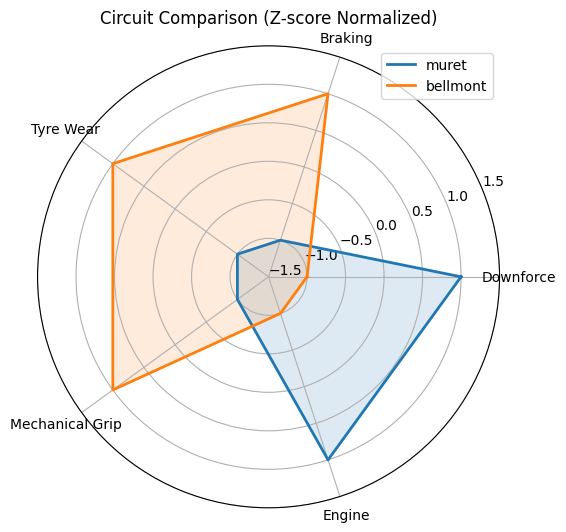

In [10]:
plot_circuit_radar_zscore(features_muret, features_belmont, labels=('muret', 'bellmont'))

## Radar Plot

In [11]:
labels = list(features.keys())
values = np.array(list(features.values()))

# Normalize
values = 100 * values / values.max()
values = np.append(values, values[0])

angles = np.linspace(0, 2*np.pi, len(labels)+1)

plt.figure(figsize=(6,6))
axp = plt.subplot(111, polar=True)
axp.plot(angles, values)
axp.fill(angles, values, alpha=0.3)
axp.set_thetagrids(angles[:-1]*180/np.pi, labels)
axp.set_title('Circuit Characteristics Radar')
plt.show()

NameError: name 'features' is not defined

## Circuit Map (GPS)

In [12]:
def plot_track(df, label):
    plt.figure(figsize=(6,6))
    plt.plot(df['GPS Longitude'], df['GPS Latitude'])
    plt.axis('equal')
    plt.title(f'{label} Layout (GPS)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

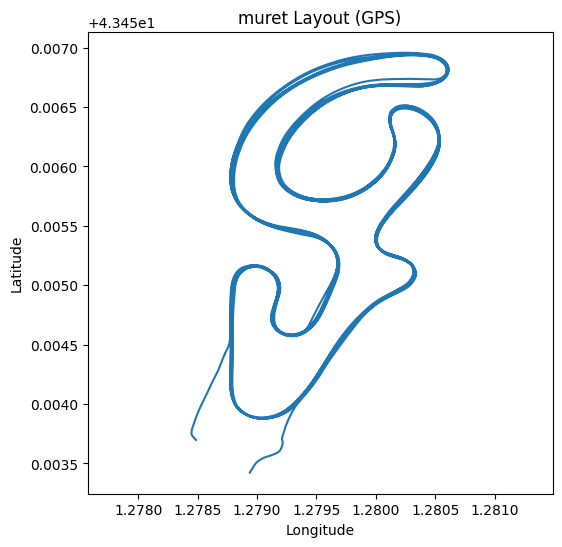

In [13]:
plot_track(muret, "muret")

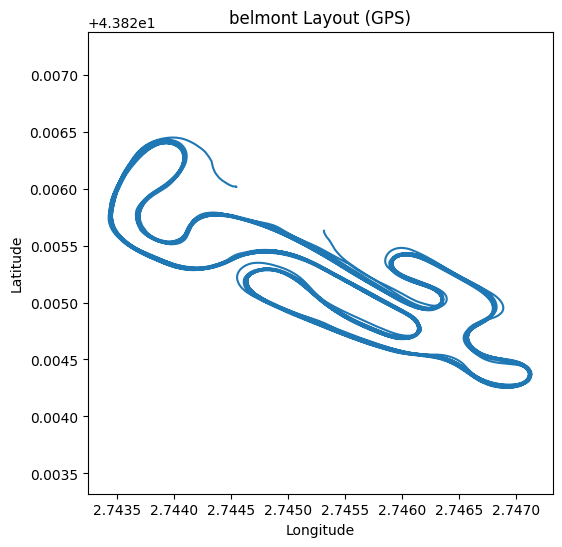

In [48]:
plot_track(belmont, "belmont")